In [4]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
import plotly.io as pio
init_notebook_mode()
#standard libraries
import numpy as np #linear algebra
import pandas as pd #data processing, I/O operations
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates #dates format
%matplotlib inline
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import sklearn
print(sklearn.__version__)

1.3.2


In [5]:
from datetime import datetime
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
dateparse = lambda dates:datetime.strptime(dates, '%m/%d/%Y')

In [6]:
#df = pd.read_csv('btcPrice-final.csv',sep=',', parse_dates=['Date'], date_parser=dateparse,  index_col=['Date'],low_memory=False)
# df = pd.read_csv('btcPrice-final.csv',sep=',', index_col=['Date'],low_memory=False,parse_dates = ['Date'],
#                  converters={'Date': lambda x: pd.to_datetime(x).strftime('%Y-%m-%d') })                                       

df = pd.read_csv('btcPrice-final_2024.csv', sep=',', parse_dates=['Date'], index_col=['Date'], date_parser=dateparse)
df = df.tail(100000)


C:\Users\Rostami_pc\AppData\Local\Temp\ipykernel_28780\4055546178.py:5: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [7]:
df.describe()

Price          Open          High           Low          Vol.  \
count    890.000000    890.000000    890.000000    890.000000    890.000000   
mean   33993.938202  33967.974157  34645.652809  33277.746067   2938.161966   
std    14632.896049  14590.362595  14931.717345  14236.466644  10343.659806   
min    15776.000000  15777.000000  16275.000000  15504.000000     11.070000   
25%    22959.750000  22959.750000  23392.000000  22536.000000     62.907500   
50%    29230.500000  29230.500000  29685.500000  28857.500000    201.635000   
75%    42032.250000  42032.750000  42806.000000  41239.750000    720.555000   
max    72974.000000  72985.000000  73666.000000  71172.000000  75284.000000   

              RSI  
count  889.000000  
mean    34.899029  
std     24.405220  
min      0.000000  
25%      0.000000  
50%     41.073264  
75%     52.588041  
max     89.262131

In [8]:
df.head()

Price   Open   High    Low   Vol.     Change         RSI     Date2
Date                                                                          
2022-01-01  47738  46218  47918  46218  31.24   32900.00%  42.788903  1/1/2022
2022-01-02  47312  47739  47945  46718  27.02   -8900.00%  40.289948  1/2/2022
2022-01-03  46430  47294  47556  45704  41.06  -18600.00%  38.655362  1/3/2022
2022-01-04  45837  46436  47505  45602  55.59  -12800.00%  32.824458  1/4/2022
2022-01-05  43426  45833  47019  42535  83.74  -52600.00%  32.114730  1/5/2022

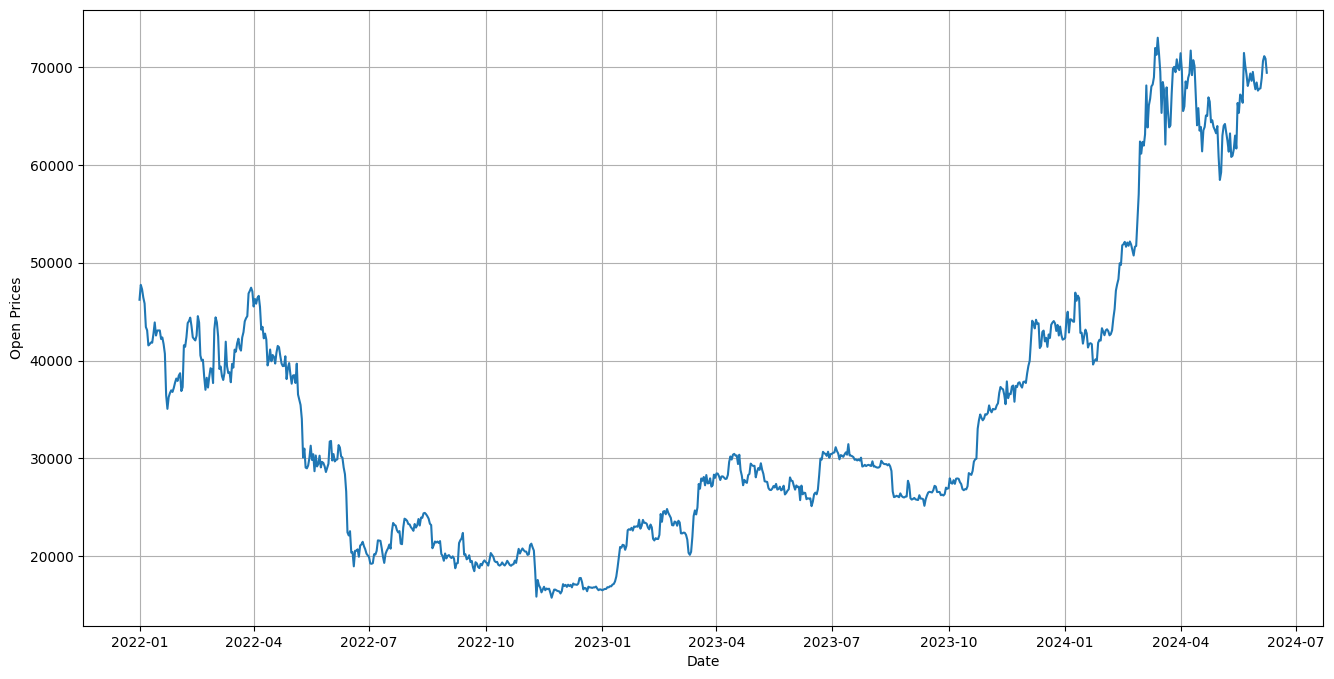

In [9]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(df['Open'])
plt.show()

In [10]:
values = pd.DataFrame(df['Open'].values)
dataframe = pd.concat([values, values.shift(1), values.shift(5), values.shift(10), values.shift(30)], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
dataframe.head(5)

t      t+1  t+5  t+10  t+30
0  46218      NaN  NaN   NaN   NaN
1  47739  46218.0  NaN   NaN   NaN
2  47294  47739.0  NaN   NaN   NaN
3  46436  47294.0  NaN   NaN   NaN
4  45833  46436.0  NaN   NaN   NaN

In [11]:
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.997224  0.986763  0.974122  0.918040
t+1   0.997224  1.000000  0.989552  0.976325  0.921522
t+5   0.986763  0.989552  1.000000  0.986352  0.932638
t+10  0.974122  0.976325  0.986352  1.000000  0.942802
t+30  0.918040  0.921522  0.932638  0.942802  1.000000


In [12]:
def tsplot(y, lags=None, figsize=(14, 8), stle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout=(2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

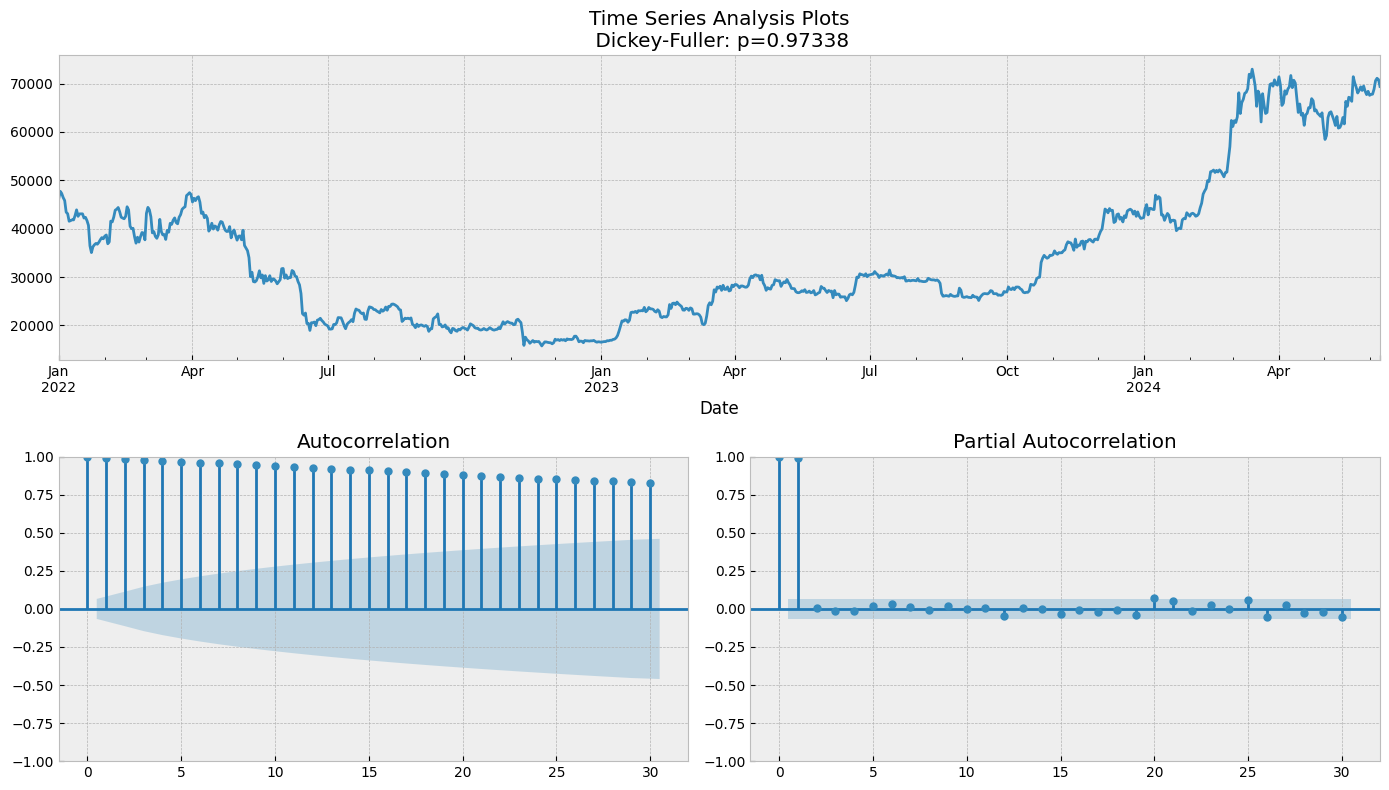

In [13]:
tsplot(df.Open, lags=30)

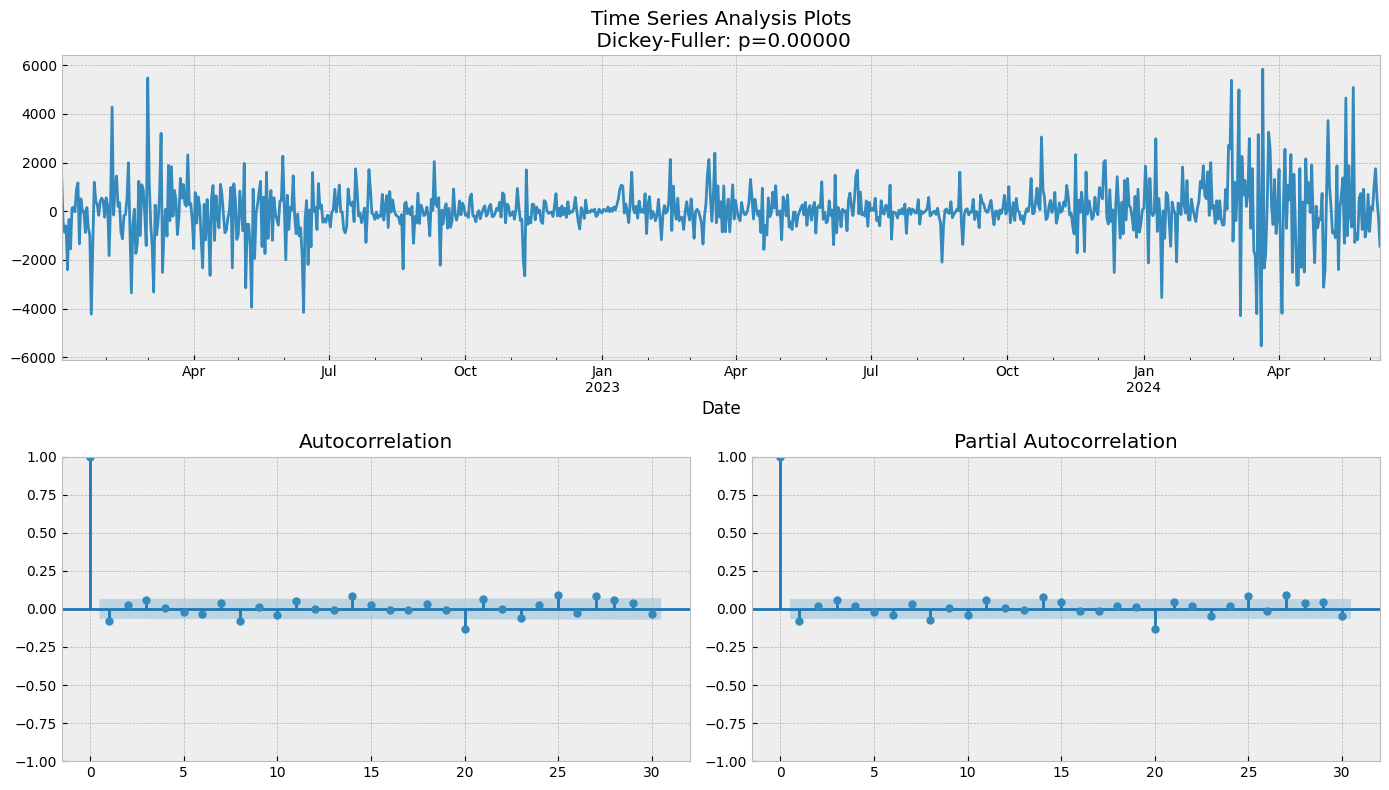

In [14]:
data = df.copy(deep=False)
data1 = df.copy(deep=False)
data1.Open = data1.Open - data1.Open.shift(1)
tsplot(data1.Open[1:], lags=30)

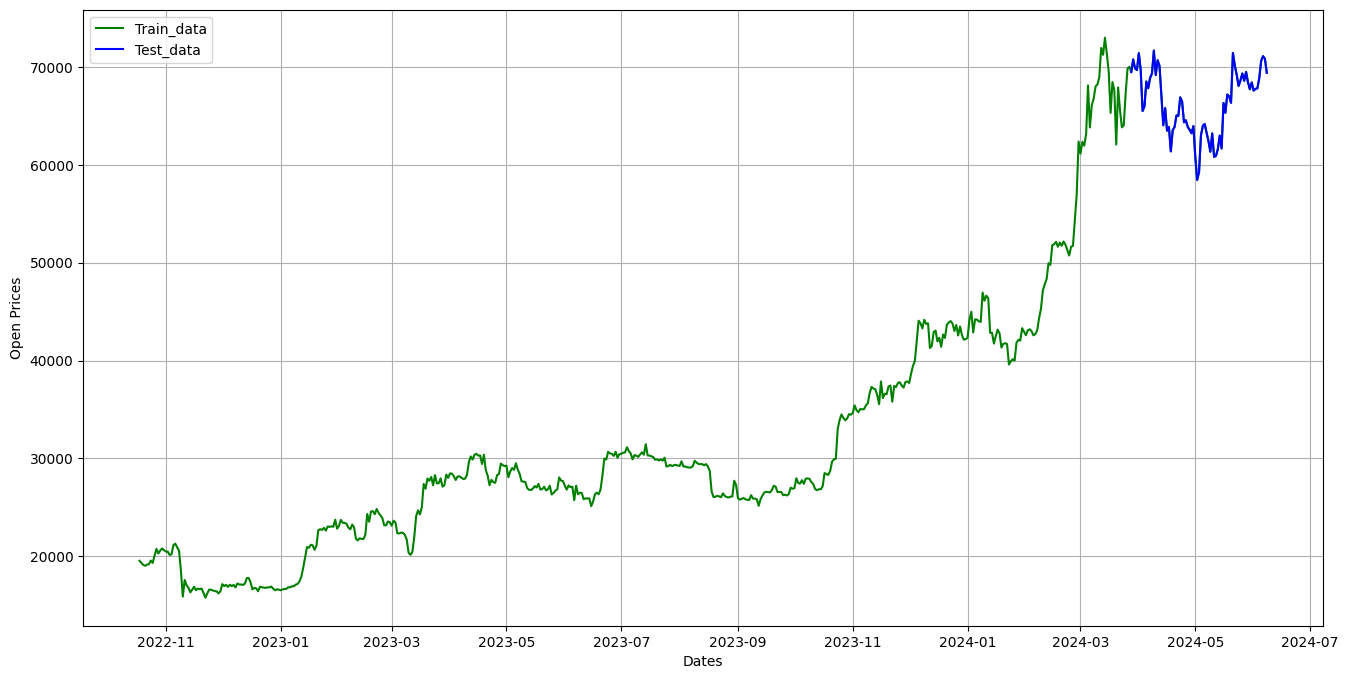

In [15]:
train_data, test_data = data[1:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.legend()
plt.show()


In [16]:
#Mean Value plot

In [17]:
mean_value = data['Open'].mean()

mean_value

33967.97415730337

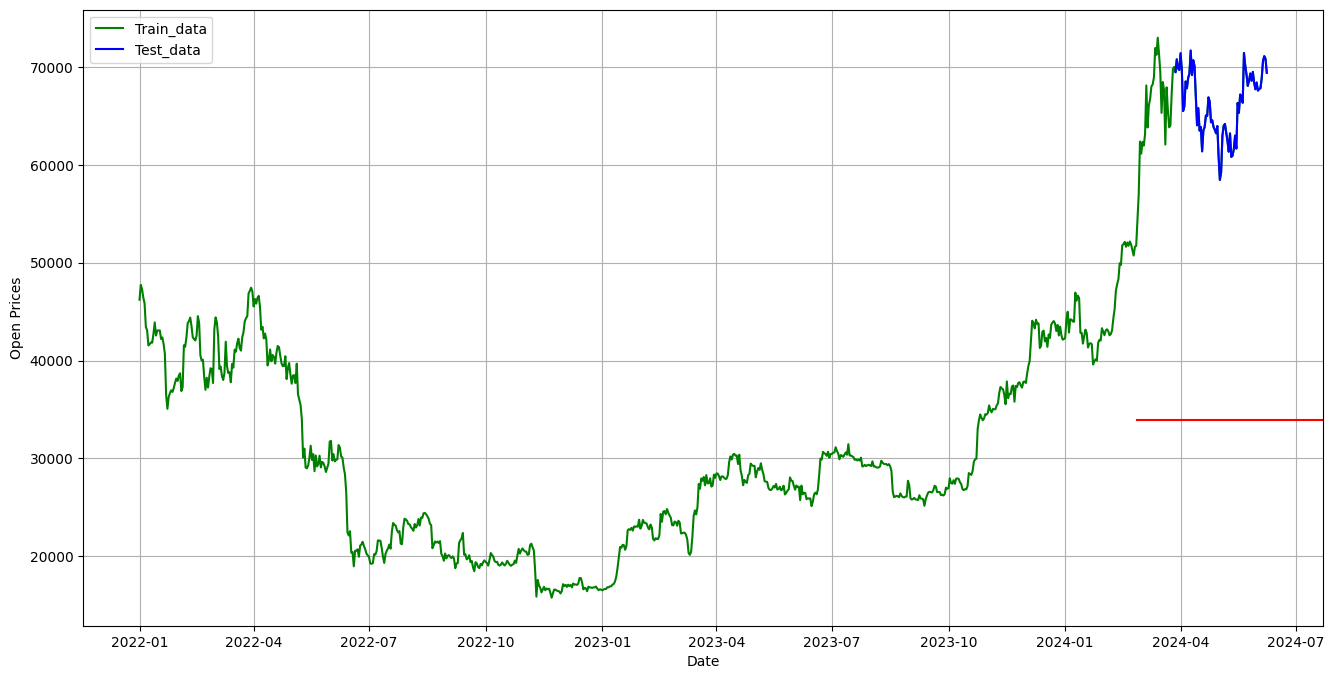

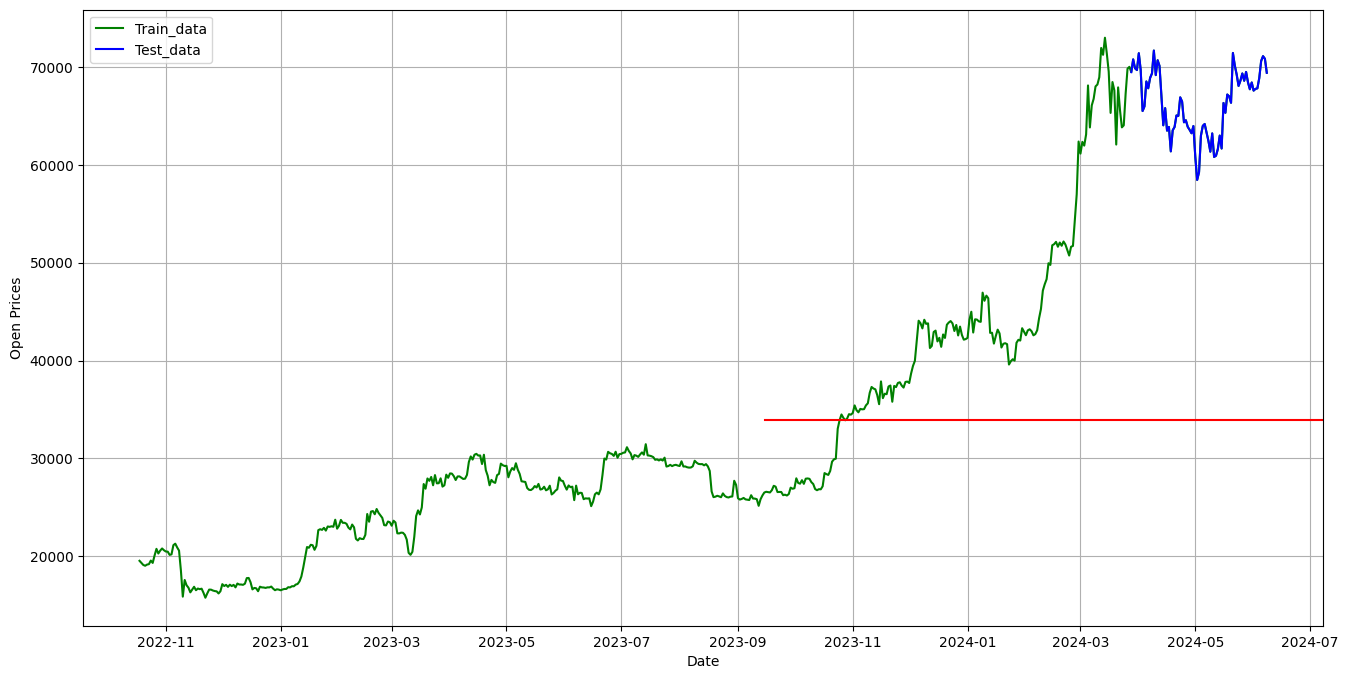

In [18]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.axhline(y=mean_value, xmin = 0.85, xmax=1, color='red')
plt.legend()

plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(data['Open'].tail(600), 'green', label='Train_data')
plt.plot(test_data['Open'], 'blue', label='Test_data')
plt.axhline(y=mean_value, xmin = 0.55, xmax=1, color='red')
plt.legend()
plt.show()

In [19]:
print('MSE:' + str(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('MAE:' + str(mean_absolute_error(test_data['Open'], np.full(len(test_data), mean_value))))
print('RMSE:' + str(sqrt(mean_squared_error(test_data['Open'], np.full(len(test_data), mean_value)))))

MSE:1058113628.4934493
MAE:32360.45050023088
RMSE:32528.65857199539


In [20]:
#Model Building and Validation
#Autoregressive model

In [21]:
train_ar = train_data['Open']
test_ar = test_data['Open']

from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train_ar, lags=31)
model_fit = model.fit()


D:\shr\Django\Machine-Learning-Specials\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [22]:
print(model_fit)
window = len(model_fit.fittedvalues)
coef = model_fit.params

In [23]:
coef

const      -30.079570
Open.L1      0.943304
Open.L2      0.076997
Open.L3      0.091244
Open.L4     -0.121311
Open.L5      0.017303
Open.L6     -0.053002
Open.L7      0.112743
Open.L8     -0.148312
Open.L9      0.189548
Open.L10    -0.198769
Open.L11     0.091720
Open.L12    -0.032341
Open.L13     0.056688
Open.L14     0.005204
Open.L15    -0.028906
Open.L16     0.007157
Open.L17    -0.061294
Open.L18     0.072514
Open.L19     0.015107
Open.L20    -0.100777
Open.L21     0.120752
Open.L22    -0.054515
Open.L23    -0.035234
Open.L24     0.066280
Open.L25     0.013511
Open.L26     0.020714
Open.L27    -0.011815
Open.L28    -0.040458
Open.L29     0.004141
Open.L30    -0.011974
Open.L31    -0.004047
dtype: float64

In [24]:
window=31

In [25]:
history = train_ar[len(train_ar) - window:]
history = [history[i] for i in range(len(history))]

C:\Users\Rostami_pc\AppData\Local\Temp\ipykernel_28780\222953650.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [26]:
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)    

C:\Users\Rostami_pc\AppData\Local\Temp\ipykernel_28780\775408039.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Rostami_pc\AppData\Local\Temp\ipykernel_28780\775408039.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Rostami_pc\AppData\Local\Temp\ipykernel_28780\775408039.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Lag: Date
2022-02-02    38500.880256
2022-02-03    38727.703692
2022-02-04    36834.828353
2022-02-05    37012.416856
2022-02-06    41318.421331
                  ...     
2024-03-23    66338.814180
2024-03-24    64384.028036
2024-03-25    64477.675384
2024-03-26    67850.132495
2024-03-27    70047.191510
Length: 785, dtype: float64


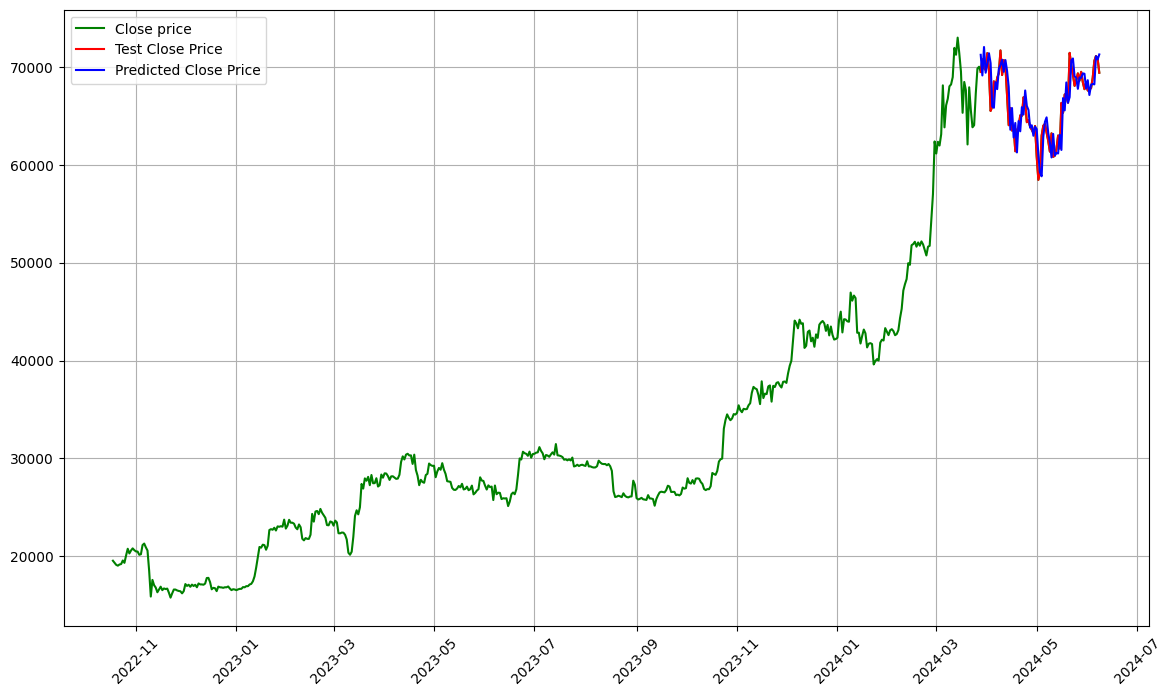

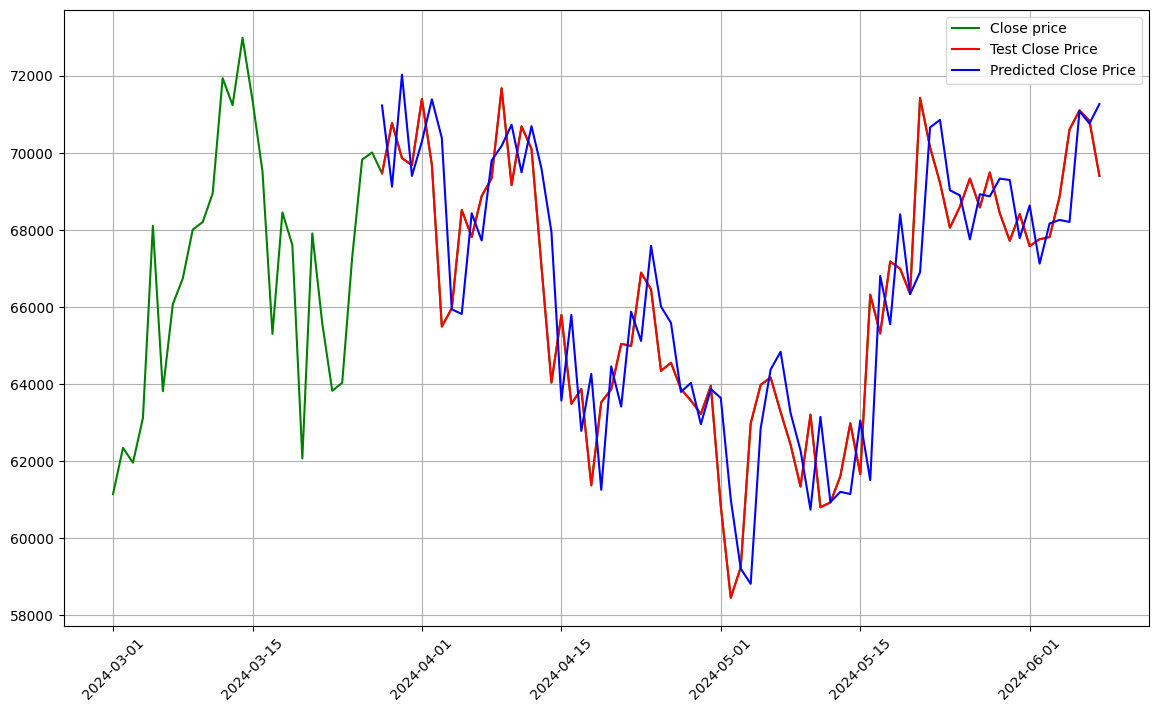

In [27]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.fittedvalues)
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Close price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Test Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [28]:
print('MSE:' + str(mean_squared_error(test_data['Open'], predictions)))
print('MAE:' + str(mean_absolute_error(test_data['Open'], predictions)))
print('RMSE:' + str(sqrt(mean_squared_error(test_data['Open'], predictions))))

MSE:3281626.609952709
MAE:1407.1172240749916
RMSE:1811.526044514047


In [29]:
#Moving Average Model

In [35]:
#import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
# model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))
# result = model.fit()
import statsmodels.api as sm

train_ma = train_data['Open']
test_ma = test_data['Open']

history = [x for x in train_ma]
y = test_ma


predictions=list()
#old
#model = ARMA(history, order=(0,8))
# Create an ARIMA model using statsmodels.tsa.arima.model.ARIMA
model = sm.tsa.ARIMA(data, order=(0,0,8)).fit()
print(model)
# model_fit = model.fit(disp=0)
# yhat = model_fit.forecast()[0]
# predictions.append(yhat)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
history.append(y[0])
for i in range(1, len(y)):
    model = ARMA(history, order=(0,8))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock price')
plt.plot(test_data.index, y, color='red', label='Real Close Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['Open'].tail(100), color='green', label = 'Train Stock price')
plt.plot(test_data.index, y, color='red', label='Real Stock Price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted Stock Price')
plt.grid(True)
plt.legend()
plt.show()